In [21]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Phase_Retrieval/Conferencia/utils")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
from LoadData import DataGenerator
from AcquisitionLayer import Muestreo
#from InitializationLayer import FSI
from pruebas_layers import ProposedInitializationModelUnrolledWithUnet, customGaussian
#from FinalModel import ProposedInitializationModelUnrolled
from CallBacks import SaveResults_CBMNIST
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from loss_and_metrics import *
from scipy.io import savemat, loadmat

In [23]:
BATCH_SIZE = 32
dim = (256,256)

RESULTS_DIR = "../results"

DATASET_DIR = "../DATASET"
lista_archivos = []
lista_archivos = lista_archivos+[ os.path.join(DATASET_DIR, "TRAIN", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "TRAIN"))]
lista_archivos = lista_archivos+[ os.path.join(DATASET_DIR, "TEST", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "TEST"))]
lista_archivos = lista_archivos+[ os.path.join(DATASET_DIR, "VALIDATION", archivo) for archivo in os.listdir(os.path.join(DATASET_DIR, "VALIDATION"))]
train_files, test_files = train_test_split(lista_archivos,test_size=0.2, random_state=84)
test_files, validation_files = train_test_split(test_files,test_size=0.5, random_state=84)



train_generator = DataGenerator(train_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
test_generator = DataGenerator(test_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)
validation_generator = DataGenerator(validation_files, batch_size=BATCH_SIZE, dim=dim, shuffle=False)

#X = test_generator.__getitem__(6)[0]
# train_generator = DataGenerator(x_train, BATCH_SIZE, dim)
# test_generator = DataGenerator(x_test, BATCH_SIZE, dim)



In [24]:
os.path.join(DATASET_DIR, "VALIDATION", "DOI1007.mat") in train_files

True

In [25]:
path = DATASET_DIR+"/VALIDATION/DOI1007.mat"
X = validation_generator.load_image(path)
X = tf.broadcast_to(X, (BATCH_SIZE, *(*dim,2)))

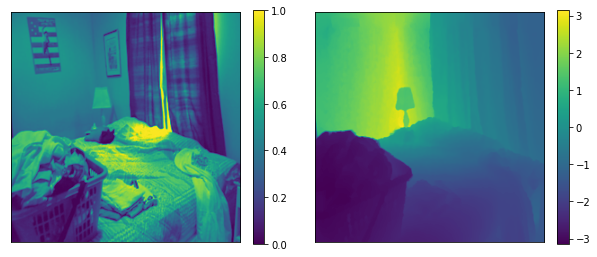

In [26]:
  fig, axs = plt.subplots(1, 2,figsize=(10,10))
  a = axs[0].imshow(X[1,:,:,0]); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
  fig.colorbar(a, ax=axs[0],fraction=0.046)
  a = axs[1].imshow(X[1,:,:,1])
  fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
  fig.show()

tf.Tensor(138.5587, shape=(), dtype=float32)
i =  0 MSE:  0.058409523 0.14431971


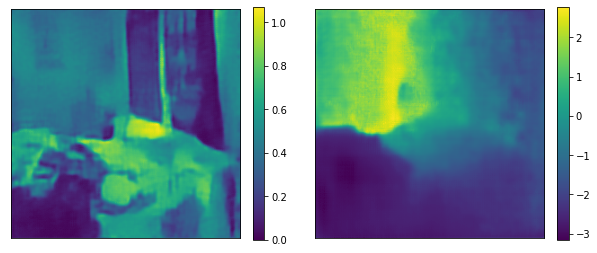

In [27]:
modelo = ProposedInitializationModelUnrolledWithUnet(1, None, init = False, use_generator = True)
modelo.build( (BATCH_SIZE, *(*dim,2)))
modelo.load_weights(os.path.join(RESULTS_DIR, "SNR_Noneinit_False_last_weights.h5"))
salida = modelo(X)
mse = tf.keras.losses.MeanAbsoluteError()
for i in range(1):
  abs = salida[-2][i,:,:]
  ang = salida[-1][i,:,:]

  ang = (ang * 2*np.pi)-np.pi
  abs_x = X[i,:,:,0]
  ang_x = X[i,:,:,1]

  #x,z = X[0,...], salida[]
  
  print(RE(X[i,...],tf.concat([tf.expand_dims(abs,-1), tf.expand_dims(ang,-1)], 2)))
  print("i = ", i, "MSE: ", mse(abs_x, abs).numpy(), mse(tf.math.sin(ang_x), tf.math.sin(ang)).numpy())
  fig, axs = plt.subplots(1, 2,figsize=(10,10))
  a = axs[0].imshow(abs); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
  fig.colorbar(a, ax=axs[0],fraction=0.046)
  a = axs[1].imshow(ang)
  fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
  fig.show()

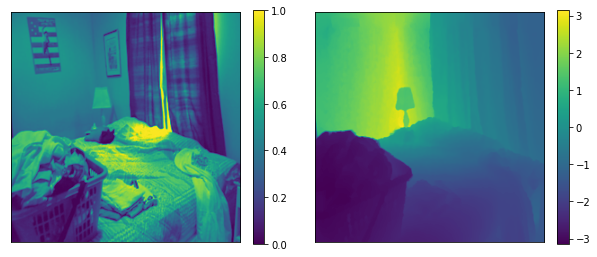

In [28]:
  fig, axs = plt.subplots(1, 2,figsize=(10,10))
  a = axs[0].imshow(abs_x); plt.sca(axs[0]); plt.yticks([]); plt.xticks([])
  fig.colorbar(a, ax=axs[0],fraction=0.046)
  a = axs[1].imshow(ang_x)
  fig.colorbar(a, ax=axs[1],fraction=0.046); plt.sca(axs[1]); plt.yticks([]); plt.xticks([])
  fig.show()

In [29]:
abs.shape

TensorShape([256, 256])

In [30]:
  dict_kernel = {"img_abs":abs.numpy().tolist(),
                "img_ang":ang.numpy().tolist()}

  savemat(os.path.join(RESULTS_DIR, "imagen_unet.mat"), dict_kernel)